In [1]:
import os
import datetime
import snap
import seaborn           as sns
import matplotlib.pyplot as plt

from src.helper_funcs    import make_genders_dict
from src.helper_funcs    import eliminate_no_gender_nodes
from src.helper_funcs    import get_gender_counters
from src.helper_funcs    import save_score_results, load_score_results
from src.fairness_funcs  import calculate_in_class_homophily
from src.fairness_funcs  import calculate_top_k_class_rate
from src.fairness_funcs  import calculate_scores
from src.fairness_funcs  import calculate_gini_coefficient

In [2]:
# PLOTTING CONFIGURATIONS

# enable inline plotting
%matplotlib inline

# set format to svg for better resolution
%config InlineBackend.figure_format = 'svg'

# apply default theme in seaborn
sns.set_theme()

### Read the names of the ego networks

---

In [3]:
# Read ego network filenames
gplus_dir = "datasets/g_plus/gplus"
ego_net_filenames = []

# Read ego network names
for filename in os.listdir(gplus_dir):
    ego_net_filenames.append(filename.split('.')[0])
    
# Keep name only once

ego_net_filenames = list(dict.fromkeys(ego_net_filenames))

### Calculate scores

---

- Calculate scores based on *ranking_algorithms* algorithms
- Save scores in files for later processing

In [5]:
# Calculate rankings for every ego network and save them for processing later
ranking_algorithms = ['pagerank', 'eccentricity']

processed_cnt = 0
for ego_net_filename in ego_net_filenames:
    # Load network
    (graph, nodes_mapping) = snap.LoadEdgeListStr(snap.TNGraph,
                                                  f"{os.path.join(gplus_dir, ego_net_filename)}.edges",
                                                  Mapping=True)
    
    # Create dictionary with the gender of each node
    genders_dict = make_genders_dict(f"{os.path.join(gplus_dir, ego_net_filename)}.feat",
                                     nodes_mapping,
                                     1,
                                     3)
    
    # Eliminate no gender nodes
    graph, genders_dict = eliminate_no_gender_nodes(graph, genders_dict)
    
    # Calculate gender counters
    gender_counters = get_gender_counters(genders_dict)
    
    # ----------
    # Calculate scores based on given algorithms
    for ranking_alg in ranking_algorithms:
        scores = calculate_scores(graph,
                                  algorithm=ranking_alg,
                                  sorted_bool=True)
        
        # Write to file
        save_score_results(directory_path=f"ranking_scores/gplus/{ranking_alg}",
                           network_name=ego_net_filename,
                           algorithm_str=ranking_alg,
                           scores=scores,
                           genders_dict=genders_dict,
                           mapping=nodes_mapping)

    # ----------
    
    # A simple print for log
    processed_cnt += 1
    if processed_cnt % 5 == 0:
        print(f"[{datetime.datetime.now()}]: {processed_cnt}/{len(ego_net_filenames)} networks are processed")

[2022-06-08 21:28:03.031036]: 5/125 networks are processed
[2022-06-08 21:29:25.228793]: 10/125 networks are processed
[2022-06-08 21:31:50.763653]: 15/125 networks are processed
[2022-06-08 21:38:35.629047]: 20/125 networks are processed
[2022-06-08 21:39:26.703670]: 25/125 networks are processed
[2022-06-08 21:40:36.079709]: 30/125 networks are processed
[2022-06-08 21:47:41.382353]: 35/125 networks are processed
[2022-06-08 21:50:57.171874]: 40/125 networks are processed
[2022-06-08 21:58:46.416364]: 45/125 networks are processed
[2022-06-08 22:04:32.498738]: 50/125 networks are processed
[2022-06-08 22:07:12.332851]: 55/125 networks are processed
[2022-06-08 22:13:38.410865]: 60/125 networks are processed
[2022-06-08 22:16:46.271597]: 65/125 networks are processed
[2022-06-08 22:19:20.531854]: 70/125 networks are processed
[2022-06-08 22:20:44.727545]: 75/125 networks are processed
[2022-06-08 22:24:53.412336]: 80/125 networks are processed
[2022-06-08 22:26:58.094622]: 85/125 netw

---

### Inequality evaluation



In [7]:
directory_gplus = 'datasets/g_plus/gplus'
# directory_scores = 'ranking_scores/gplus/pagerank'
directory_scores = 'ranking_scores/gplus/eccentricity'

majority_homophilies = []
minority_homophilies = []
inequality_top_k_ecc = dict.fromkeys(range(10, 110, 10), 0)

# Read scores
num_of_files = 0
for filename in os.listdir(directory_scores):
    num_of_files += 1
    # Naming format: '<ego_net>_<algorithm>_scores.txt'
    ego_net_filename = filename.split('_')[0]

    # Load scores
    scores, genders = load_score_results(os.path.join(directory_scores, filename))

    # Calculate GINI coefficient for every k in inequality top-k dict
    for k in inequality_top_k_ecc:
        num_of_top_k_scores = round(len(scores)*k/100)
        inequality_top_k_ecc[k] += calculate_gini_coefficient(scores[:num_of_top_k_scores])

    if num_of_files % 5 == 0:
        print(f"[{datetime.datetime.now()}]: {num_of_files} networks are processed")

# Calculate average
inequality_top_k_ecc = {k: v/num_of_files for k, v in inequality_top_k_ecc.items()}

[2022-06-13 13:52:35.360549]: 5 networks are processed
[2022-06-13 13:53:49.869118]: 10 networks are processed
[2022-06-13 13:54:57.081752]: 15 networks are processed
[2022-06-13 13:56:49.567225]: 20 networks are processed
[2022-06-13 13:57:23.339366]: 25 networks are processed
[2022-06-13 13:57:42.404553]: 30 networks are processed
[2022-06-13 13:59:23.320451]: 35 networks are processed
[2022-06-13 14:01:40.504863]: 40 networks are processed
[2022-06-13 14:04:24.248968]: 45 networks are processed
[2022-06-13 14:08:19.817019]: 50 networks are processed
[2022-06-13 14:09:33.194940]: 55 networks are processed
[2022-06-13 14:11:05.754923]: 60 networks are processed
[2022-06-13 14:12:32.664778]: 65 networks are processed
[2022-06-13 14:13:47.612892]: 70 networks are processed
[2022-06-13 14:14:07.391388]: 75 networks are processed
[2022-06-13 14:15:48.959147]: 80 networks are processed
[2022-06-13 14:17:05.252306]: 85 networks are processed
[2022-06-13 14:18:18.493521]: 90 networks are pro

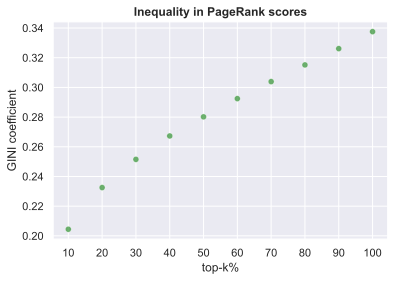

In [6]:
sc_plot = sns.scatterplot(x=list(inequality_top_k.keys()),
                          y=list(inequality_top_k.values()),
                          alpha=0.65,
                          color='forestgreen')

sc_plot.set_title('Inequality in PageRank scores', weight='bold')
sc_plot.set_xlabel('top-k%')
sc_plot.set_ylabel('GINI coefficient')
sc_plot.set_xticks(list(inequality_top_k.keys()))

# plt.savefig('pagerank_inequality.png', dpi=1500)
plt.show()

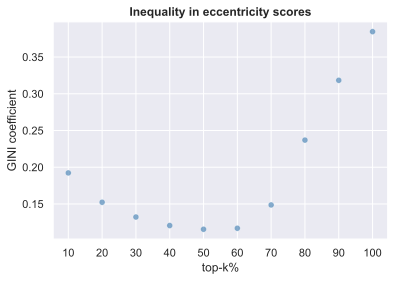

In [9]:
sc_plot = sns.scatterplot(x=list(inequality_top_k_ecc.keys()),
                          y=list(inequality_top_k_ecc.values()),
                          alpha=0.65,
                          color='steelblue')

sc_plot.set_title('Inequality in eccentricity scores', weight='bold')
sc_plot.set_xlabel('top-k%')
sc_plot.set_ylabel('GINI coefficient')
sc_plot.set_xticks(list(inequality_top_k_ecc.keys()))

# plt.savefig('eccentricity_inequality.png', dpi=1500)
plt.show()

---

### Inequity evaluation

$$
Inequity = \frac{top\_k\_minority - overall\_minority}{overall\_minority}
$$

Inequity value > 0: Over-representation of minority <br>

Inequity value < 0: Under-representation of minority

In [12]:
directory_gplus = 'datasets/g_plus/gplus'
# directory_scores = 'ranking_scores/gplus/pagerank'
directory_scores = 'ranking_scores/gplus/eccentricity'

# inequity_top_k_pr = dict.fromkeys(range(5, 105, 5), 0)
inequity_top_k_ecc = dict.fromkeys(range(5, 105, 5), 0)

# Read scores
num_of_files = 0
for filename in os.listdir(directory_scores):
    num_of_files += 1
    # Naming format: '<ego_net>_<algorithm>_scores.txt'
    ego_net_filename = filename.split('_')[0]

    # Load scores
    scores, genders = load_score_results(os.path.join(directory_scores, filename))
    
    # Find minority class
    minority_class = 2 if genders.count(1) > genders.count(2) else 1
    
    # Calculate minority global representation
    minority_repr_global = genders.count(minority_class)/len(genders)
    
    for k in inequity_top_k_ecc:
        num_of_top_k = round(len(genders)*k/100)
        # Calculate minority local representation in top-k% positions
        minority_repr_top_k = genders[:num_of_top_k].count(minority_class)/len(genders[:num_of_top_k])
        
        # Calculate inequity value
        inequity_value = (minority_repr_top_k - minority_repr_global) / minority_repr_global
        inequity_top_k_ecc[k] += inequity_value

#     if num_of_files % 5 == 0:
#         print(f"[{datetime.datetime.now()}]: {num_of_files} networks are processed")

# Calculate average
inequity_top_k_ecc = {k: v/num_of_files for k, v in inequity_top_k_ecc.items()}
print(inequity_top_k_ecc)

{5: -0.07499876063434854, 10: -0.0858716352908053, 15: -0.07985373739815398, 20: -0.07142554482767463, 25: -0.07538275380975511, 30: -0.07169812273991931, 35: -0.07940215320513526, 40: -0.07590864426375231, 45: -0.06762602556486746, 50: -0.06115427199949141, 55: -0.05712380527039104, 60: -0.048711544310864045, 65: -0.037902744610295185, 70: -0.03390216968778002, 75: -0.02607090753178241, 80: -0.02162048449247952, 85: -0.01387984816727941, 90: -0.008273732360001075, 95: -0.008007606561814996, 100: 0.0}


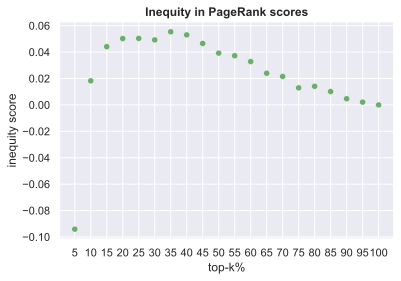

In [11]:
sc_plot = sns.scatterplot(x=list(inequity_top_k_pr.keys()),
                          y=list(inequity_top_k_pr.values()),
                          alpha=0.65,
                          color='forestgreen')

sc_plot.set_title('Inequity in PageRank scores', weight='bold')
sc_plot.set_xlabel('top-k%')
sc_plot.set_ylabel('inequity score')
sc_plot.set_xticks(list(inequity_top_k_pr.keys()))

# plt.savefig('pagerank_inequity.png', dpi=1500)
plt.show()

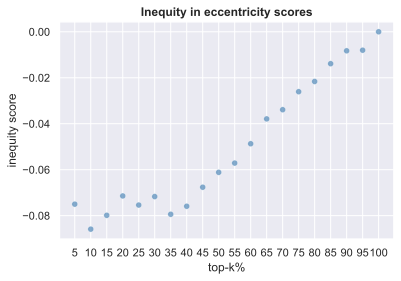

In [13]:
sc_plot = sns.scatterplot(x=list(inequity_top_k_ecc.keys()),
                          y=list(inequity_top_k_ecc.values()),
                          alpha=0.65,
                          color='steelblue')

sc_plot.set_title('Inequity in eccentricity scores', weight='bold')
sc_plot.set_xlabel('top-k%')
sc_plot.set_ylabel('inequity score')
sc_plot.set_xticks(list(inequity_top_k_ecc.keys()))

# plt.savefig('eccentricity_inequity.png', dpi=1500)
plt.show()